# Соберем сверточную нейронную сеть LiNet5

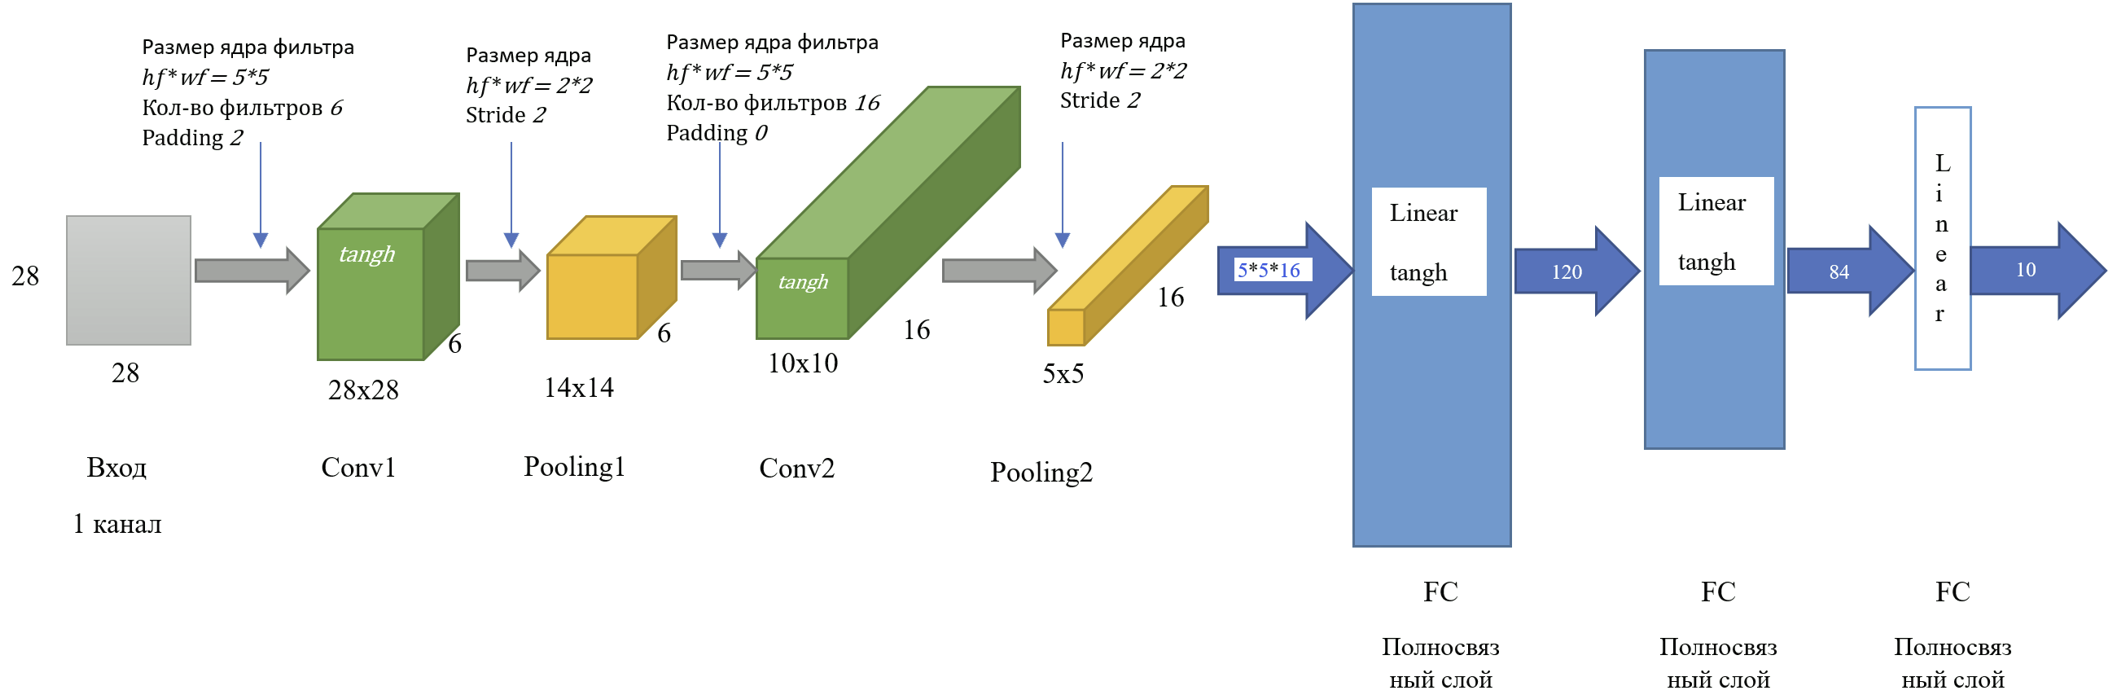


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет $28 \times 28$, функция активации $tangh$;

**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет $14 \times 14$, функция активации $AvgPooling$;

**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет $10 \times 10$, функция активации $tangh$;

**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет $5 \times 5$, функция активации $AvgPooling$;

**Слой FC** представляет собой полносвязанный слой, вход $5 \times 5 \times 16$ нейронов (признаков), выход $120$ нейронов, функция активации $tangh$;

**Слой FC** представляет собой полносвязанный слой, вход $120$ нейронов (признаков), выход $84$ нейрона, функция активации $tangh$;

**Слой FC** представляет собой полносвязанный слой, вход $84$ нейронов (признаков), выход $10$ нейронов;



In [ ]:
# импортируем библиотеки

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
# это для cuda .
#torch.cuda.memory_summary(device=None, abbreviated=True)

In [ ]:
# это для cuda. принудительно освобождение памяти, что иногда, но очень редко, помогает решить проблему с отказом
# cuda использовать память
#import gc
#gc.collect()

#torch.cuda.empty_cache()

In [ ]:
# будем использовать встроенные датасеты торча.
# полный список - тут https://pytorch.org/vision/stable/datasets.html


import torchvision.datasets

In [ ]:
# загружаем сразу в трайн и тест
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.38MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# формируем датасеты для обучения, тестирования, целевые переменные
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

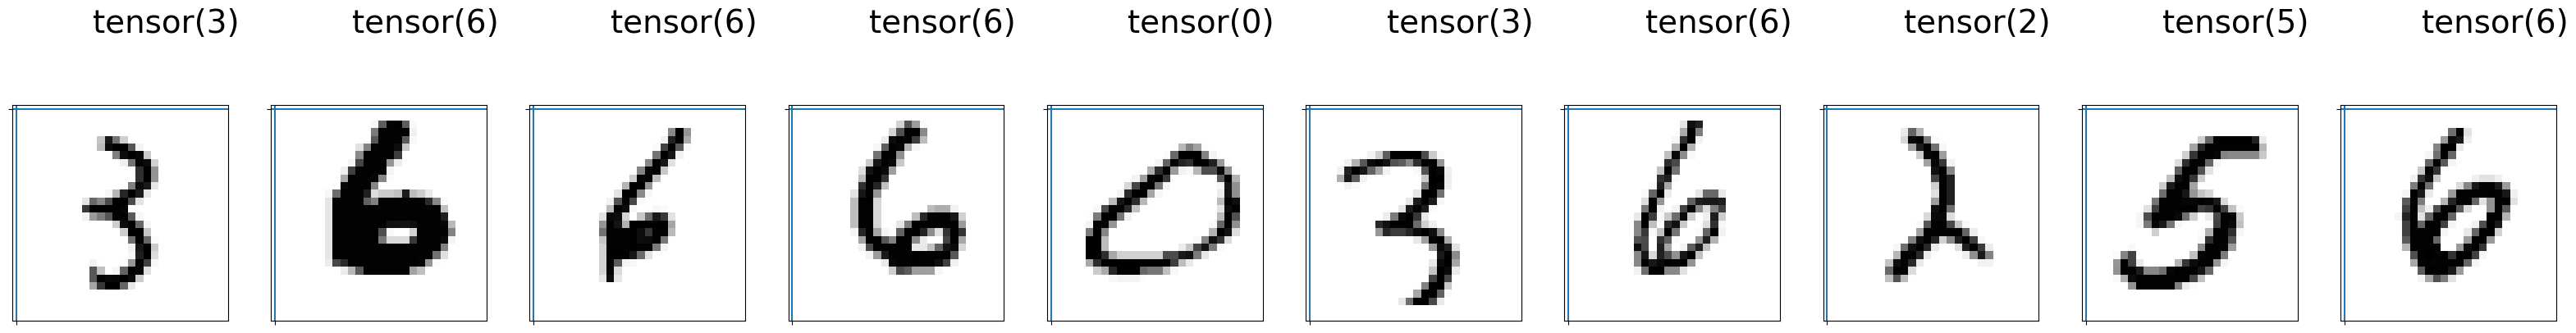

In [ ]:
# посмотрим, что пришло

import numpy as np
import matplotlib.pyplot as plt

# посмотрим какие-то произвольные изображения из датасета
count = 0
sample_size = 10  # сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=28)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [ ]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(60000, 10000)

image:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 

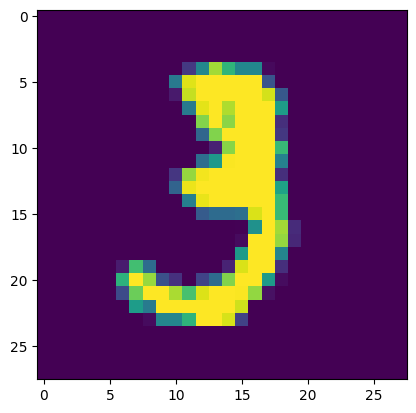

tensor(3)


In [ ]:
# нарисуем, c чем мы имеем дело
import matplotlib.pyplot as plt

im_number = 10

# вот как хранятся изображения в компьютере
print(f"image:\n{X_train[im_number, :, :]}")

# а так их видим мы
plt.imshow(X_train[im_number, :, :])

plt.show()
print(y_train[im_number])

In [ ]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

In [ ]:
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# было torch.Size([60000, 28, 28])  ---- станет torch.Size([60000, 1, 28, 28])
# и все значения - во float

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
X_test.shape

torch.Size([10000, 1, 28, 28])

In [ ]:
# Определяем класс, которые и будет представлять нашу нейронку
# какие слои - см описание вначале блокнота

class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [ ]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

NameError: name 'lenet5' is not defined

# ЕСЛИ ВЫ ОБУЧИТЕ НЕЙРОНКУ НА GPU или CPU ОНА ДЛЯ СВОЕЙ РАБОТЫ БУДЕТ ТРЕБОВАТЬ ИЛИ GPU, ИЛИ CPU
Поэтому не всегда возможно использование обучения на GPU просто потому, что сервер или компьютер пользователя не будет поддерживать расчеты на GPU

In [ ]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [ ]:
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []


train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())


    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.9745000004768372 
epoch1 - accuracy test 0.9807999730110168 
epoch2 - accuracy test 0.9856999516487122 
epoch3 - accuracy test 0.986299991607666 
epoch4 - accuracy test 0.9866999983787537 
epoch5 - accuracy test 0.9871999621391296 
epoch6 - accuracy test 0.9893999695777893 
epoch7 - accuracy test 0.9886999726295471 
epoch8 - accuracy test 0.9878000020980835 
epoch9 - accuracy test 0.9887999892234802 
epoch10 - accuracy test 0.9900999665260315 
epoch11 - accuracy test 0.9882999658584595 
epoch12 - accuracy test 0.9886999726295471 
epoch13 - accuracy test 0.9893999695777893 
epoch14 - accuracy test 0.9870999455451965 
epoch15 - accuracy test 0.989799976348877 
epoch16 - accuracy test 0.9889999628067017 
epoch17 - accuracy test 0.9883999824523926 
epoch18 - accuracy test 0.9876999855041504 
epoch19 - accuracy test 0.9893999695777893 
epoch20 - accuracy test 0.9894999861717224 
epoch21 - accuracy test 0.9875999689102173 
epoch22 - accuracy test 0.9869999885559082 


<ipython-input-21-fd538a322c0e>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


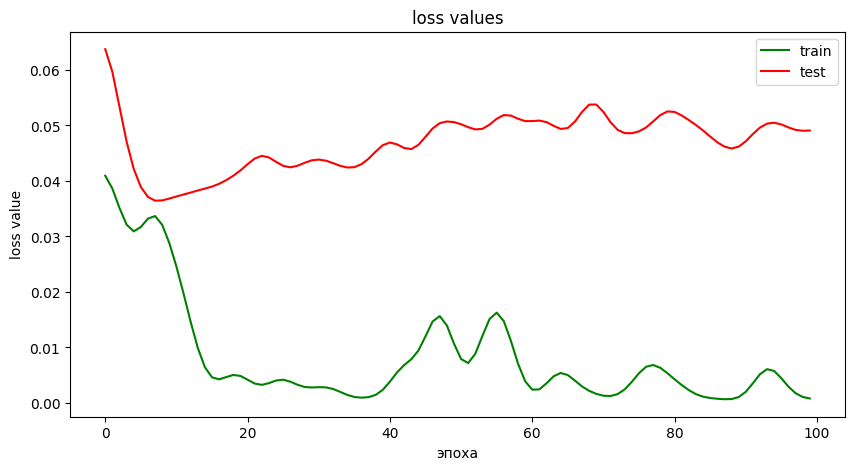

In [ ]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



<ipython-input-23-7ea75e20b699>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


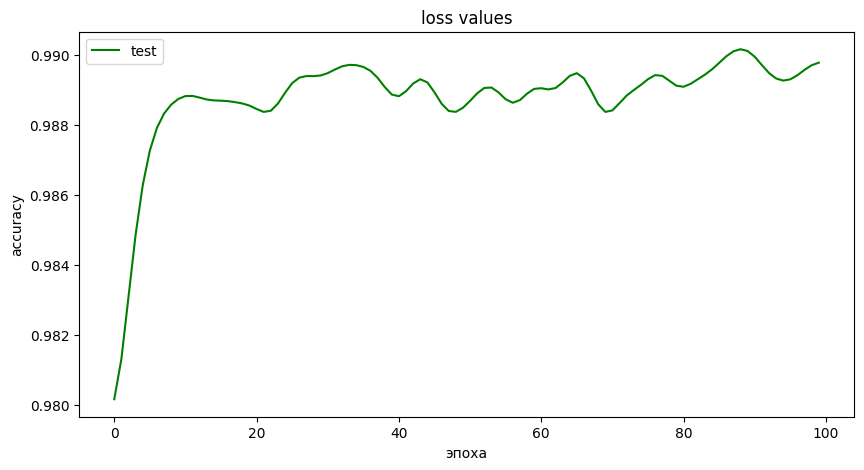

In [ ]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [ ]:
# сохраняем произвольное число из датасета (тензор) в файл
timg = X_train[0]

torch.save(timg,'tensor.pt')


In [ ]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([1, 28, 28])

In [ ]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()

# то есть нам нужен тензор размера [1,1,28,28]

torch.Size([10000, 1, 28, 28])

In [ ]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.8 MB/s eta 0:00:00


In [ ]:
# вот так сохраняют модель с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [ ]:
# вот так сохраняют модель с помощью pickle
import pickle

with open("model.pickle", "wb") as pickle_file:
    pickle.dump(lenet5, pickle_file)



In [ ]:
# считываем модель, сохраненную в dill

ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


<ipython-input-31-58d101a88a51>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


In [ ]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

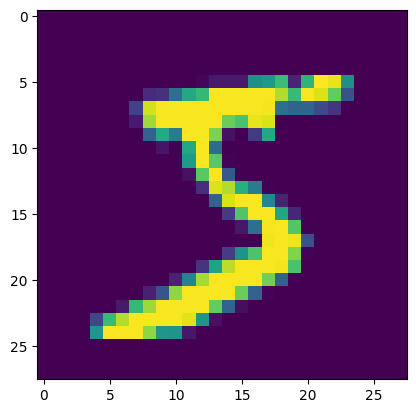

In [ ]:
# смотрим, что за цифру считали
plt.imshow(test_data[0, :, :])
plt.show()

In [ ]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

<ipython-input-34-94f1da74720b>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  t_data = torch.tensor([test_data.numpy()])


In [ ]:
# проверяем
t_data.shape

torch.Size([1, 1, 28, 28])

In [ ]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [ ]:
# делаем предсказание
preds = modelp.forward(t_data)

In [ ]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[ -3.4298,  -5.6792, -11.1934,  11.1278,  -5.4120,  22.6160,  -4.9824,
          -3.1714,   1.3048,  -4.2625]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [ ]:
# смотрим, что предсказалось
print(prediction)

[5]


Цифра предсказана верно.

**Упражнение. Выберите случайным образом изображение из тестового набора и сделайте предсказание для него.**

In [ ]:
# ваш код здесь

***Задание. Реализовать классификацию изображений на своем датасете.***

1. Выберите датасет для классификации изображений https://pytorch.org/vision/stable/datasets.html
2. Определите архитектуру нейросети и приведите ее описание (текстом или иным способом) в своей работе
3. Реализуйте выбранную архитектуру в виде класса
4. Обучите нейросеть
5. Постройте на одном графике кривые изменения функции потерь на тесте и обучении
6. Постройте график изменения выбранной метрики качества на тесте
7. Сохраните в файл одно изображение из тестовой выборки
8. Сохраните обученную нейросеть в файл
9. Загрузите изображение из файла
10. Загрузите нейросеть
11. Выполните предсказание с помощью загруженной из файла нейросети и оцените его правильность

In [2]:
import torch
import random
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import random_split, Subset

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:

transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ])

In [4]:
full_train_data = torchvision.datasets.GTSRB('./', split='train', download=True, transform=transform)


100%|██████████| 187M/187M [00:10<00:00, 18.3MB/s]


In [5]:
subset_size = int(0.2 * len(full_train_data))

In [6]:
indices = np.random.choice(len(full_train_data), size=subset_size, replace=False)

In [7]:
subset_train_data = Subset(full_train_data, indices)

In [8]:
val_size = int(0.2 * len(subset_train_data))
train_size = len(subset_train_data) - val_size


In [9]:
train_data, val_data = random_split(subset_train_data, [train_size, val_size])

test_size = val_size

full_test_data = torchvision.datasets.GTSRB('./', split='test', download=True, transform=transform)

100%|██████████| 89.0M/89.0M [00:04<00:00, 20.6MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 232kB/s]


In [10]:
test_indices = np.random.choice(len(full_test_data), size=test_size, replace=False)

# Создаем тестовое множество на основе выбранных индексов
test_data = Subset(full_test_data, test_indices)

# Теперь у вас есть train_data, val_data и test_data
print(f'Train data size: {len(train_data)}')
print(f'Validation data size: {len(val_data)}')
print(f'Test data size: {len(test_data)}')

Train data size: 4263
Validation data size: 1065
Test data size: 1065


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)


In [12]:

X_test, y_test = next(iter(test_dataloader))

In [13]:
X_train, y_train = next(iter(train_dataloader))
print(f"Feature batch shape: {X_train.size()}")
print(f"Labels batch shape: {y_train.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [14]:
class VGG16(torch.nn.Module):
    def __init__(self, num_classes=43):
        super(VGG16, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU())
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU())
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU())
        self.layer7 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU())
        self.layer9 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU())
        self.layer10 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU())
        self.layer12 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU())
        self.layer13 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(7*7*512, 4096),
            torch.nn.ReLU())
        self.fc1 = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU())
        self.fc2= torch.nn.Sequential(
            torch.nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

vgg16 = VGG16()

In [15]:
print(vgg16)

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg16 = vgg16.to(device)

In [17]:
device

device(type='cuda', index=0)

In [18]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1.0e-3)

loss = torch.nn.CrossEntropyLoss()

In [19]:
# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []


train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(15):
    for X,y in train_dataloader:
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        X_batch = X.to(device)
        y_batch = y.to(device)

        # делаем предсказание
        preds = vgg16.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    for X,y in test_dataloader:
      X_test = X_test.to(device)
      y_test = y_test.to(device)

      test_preds = vgg16.forward(X_test)
      loss_test = loss(test_preds, y_test)

    test_loss_history.append(loss_test.data.cpu())


    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.0625 
epoch1 - accuracy test 0.125 
epoch2 - accuracy test 0.125 
epoch3 - accuracy test 0.09375 
epoch4 - accuracy test 0.0625 
epoch5 - accuracy test 0.03125 
epoch6 - accuracy test 0.0625 
epoch7 - accuracy test 0.09375 
epoch8 - accuracy test 0.0625 
epoch9 - accuracy test 0.03125 
epoch10 - accuracy test 0.0 
epoch11 - accuracy test 0.09375 
epoch12 - accuracy test 0.09375 
epoch13 - accuracy test 0.09375 
epoch14 - accuracy test 0.1875 


<ipython-input-20-d82e278f75b4>:2: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


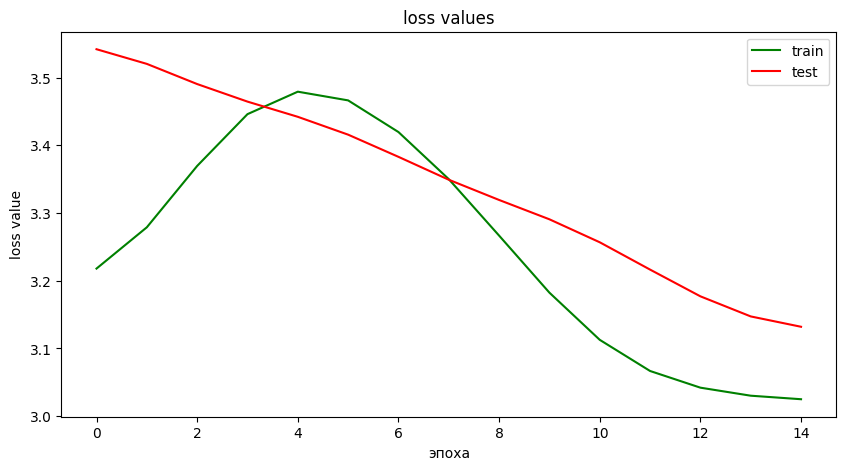

In [20]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()

<ipython-input-21-55feb07ec909>:1: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


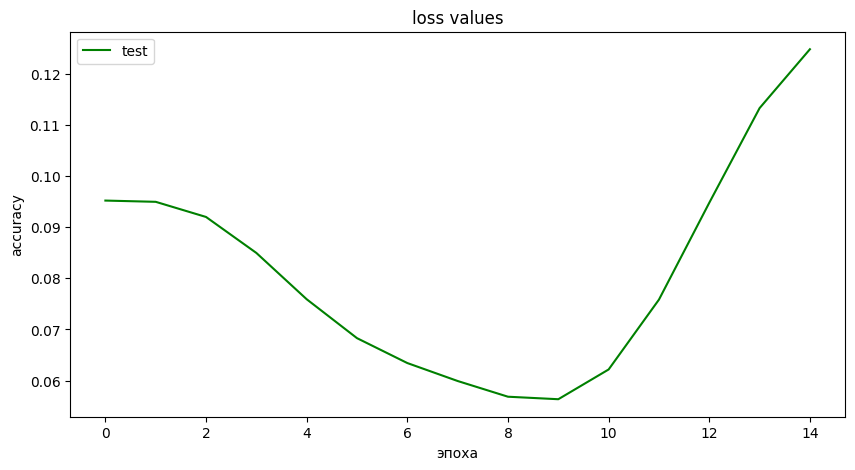

In [21]:
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


In [22]:
timg = X_test[7]

torch.save(timg,'tensor.pt')

In [23]:
y_test[7]

tensor(2, device='cuda:0')

In [24]:
timg.size()

torch.Size([3, 224, 224])

In [25]:
X_test.size()

torch.Size([32, 3, 224, 224])

In [26]:
!pip install dill

In [27]:

import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(vgg16, dill_file)

In [28]:
ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

test_data = torch.load('tensor.pt')

In [29]:
type(modelp)

__main__.VGG16

In [30]:
test_data.shape

torch.Size([3, 224, 224])

In [31]:
test_data = test_data.data.cpu()

In [33]:

t_data = torch.tensor([test_data.numpy()])

<ipython-input-33-6243146adcee>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  t_data = torch.tensor([test_data.numpy()])


In [34]:
t_data.shape

torch.Size([1, 3, 224, 224])

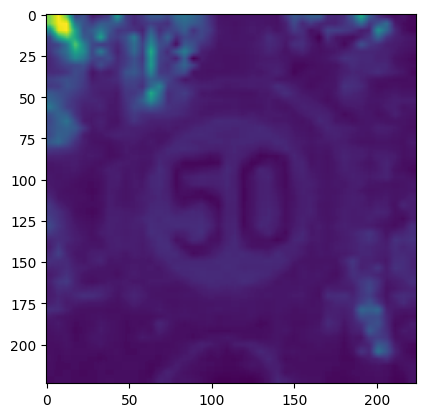

In [35]:
plt.imshow(test_data[0, :, :])
plt.show()

In [36]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

modelp.to(dev)
model_data = modelp.to(dev)

t_data = t_data.to(dev)

In [37]:
preds = modelp.forward(t_data)

In [38]:
print(preds)

tensor([[-2.7353, -0.0433,  0.0605, -0.3037, -0.0514, -0.3966, -0.4290, -0.7497,
         -0.5120, -0.4883, -0.2214, -0.0149,  1.1185,  0.5444, -1.0551, -1.3011,
         -1.4907, -0.8572,  0.0936, -1.5691, -1.3291, -1.4511, -1.0922, -1.1883,
         -1.8018,  0.1862, -0.8758, -1.3773, -0.8891, -1.8332, -1.0476, -0.5935,
         -0.9412,  0.1993, -0.5179,  0.7116, -0.3414, -1.0246,  1.1875, -0.8123,
         -0.7822, -1.0754, -1.0406]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [39]:
prediction = np.argmin(preds.to('cpu').detach().numpy(),axis=-1)

In [40]:
print(prediction)

[0]


In [45]:
val_data1 = torchvision.datasets.GTSRB('./', split='test', transform=transform)

In [46]:
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
X_val, y_val = next(iter(val_dataloader))

In [47]:
timg1 = X_val[60]

torch.save(timg1,'tensor.pt')

In [48]:
y_val[60]

tensor(18)

In [49]:
with open("model.dill", "wb") as dill_file:
    dill.dump(vgg16, dill_file)

In [50]:
ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

val_data = torch.load('tensor.pt')

In [51]:
val_data.shape

torch.Size([3, 224, 224])

In [52]:
val_data = val_data.data.cpu()

In [53]:
v_data = torch.tensor([val_data.numpy()])

In [54]:
v_data.shape

torch.Size([1, 3, 224, 224])

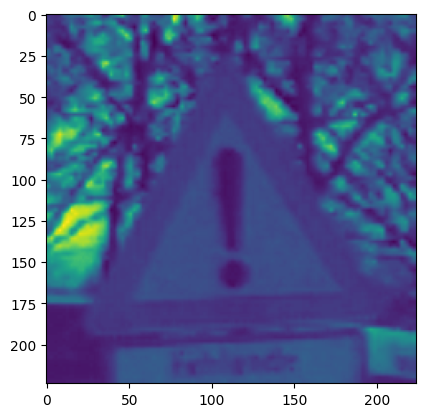

In [55]:
plt.imshow(val_data[0, :, :])
plt.show()

In [56]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

modelp.to(dev)
model_data = modelp.to(dev)

v_data = v_data.to(dev)

In [57]:
preds = modelp.forward(v_data)

In [58]:
print(preds)

tensor([[-2.7353, -0.0433,  0.0605, -0.3037, -0.0514, -0.3966, -0.4290, -0.7497,
         -0.5120, -0.4883, -0.2214, -0.0149,  1.1185,  0.5444, -1.0551, -1.3011,
         -1.4907, -0.8572,  0.0936, -1.5691, -1.3291, -1.4511, -1.0922, -1.1883,
         -1.8018,  0.1862, -0.8758, -1.3773, -0.8891, -1.8332, -1.0476, -0.5935,
         -0.9412,  0.1993, -0.5179,  0.7116, -0.3414, -1.0246,  1.1875, -0.8123,
         -0.7822, -1.0754, -1.0406]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [59]:
prediction = np.argmin(preds.to('cpu').detach().numpy(),axis=-1)


In [60]:
print(prediction)

[0]
